In [250]:
%matplotlib inline
import os
import re
import io
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [251]:
DIR_FORTRAN = os.path.join('/chia_cluster/home/jackyu/radiation',
                           'clirad-lw/LW/examples/lblnew/now')

In [252]:
PATH_FLUX = os.path.join(DIR_FORTRAN, 'output_flux.dat')
PATH_COOLR = os.path.join(DIR_FORTRAN, 'output_coolr.dat')

In [253]:
def load_lblnew_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['band', 'pressure']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    ds = xr.Dataset.from_dataframe(df)
    return ds

In [254]:
DS_FLUX = load_lblnew_output_file(PATH_FLUX)
DS_COOLR = load_lblnew_output_file(PATH_COOLR)

In [255]:
def pltdata_cooling(ds_coolr=None):
    data = [{'label': 'CLIRAD',
             'linestyle': ':', 'color': 'green', 'marker': 'D',
             'srs': ds_coolr['coolr'].sel(band=1)}]
    return data


def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 2,
                 'grid': True,
                 'alpha': .7}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():

    matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'grey',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

    pltdata = pltdata_cooling(ds_coolr=DS_COOLR,)

    fig, axs = plt_cooling(pltdata=pltdata)
    
    display.display(fig)
    print('Figure: Cooling rate profile comparison.')
    
    plt.close(fig)

In [256]:
def load_debug_bd():
    s = os.path.join(DIR_FORTRAN, 'debug_bd.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_xx():
    s = os.path.join(DIR_FORTRAN, 'debug_xx.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_h2oexps():
    s = os.path.join(DIR_FORTRAN, 'h2oexp.csv')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['layer', 'g'])
    return df


def script_debug():
    display.display(display.Markdown('# Debug Info'))
    pd.set_option('display.max_rows', None)
    display.display(load_debug_bd())
    display.display(load_debug_xx())
    display.display(load_debug_h2oexps())
    pd.reset_option('display.max_rows')


In [267]:
def load_fluxg():
    s = os.path.join(DIR_FORTRAN, 'output_fluxg.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df[df['band'] == 1]
    df = df.drop('band', axis=1)
    df = df.set_index(['g', 'pressure'])
    df = df.rename(columns={'sfd': 'fldg', 
                            'sfu': 'flug', 
                            'fnet': 'fnetg'})
    ds = xr.Dataset.from_dataframe(df)
    return ds



def load_fluxg_crd():
    s = os.path.join('/chia_cluster/home/jackyu/radiation',
                     'crd/LW/examples/separate_g_groups',
                     'study__lblnew_g1_threshold',
                     'h2o/band01_wn_20_340/nv_200',
                     'dv_0.005/ng_10',
                     'g_ascending_k_descending',
                     'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                     'ng_refs_3__2__5',
                     'getabsth_auto__auto__auto',
                     'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                     'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                     'wgt_flux_2/wgt_k_1/klin_none',
                     'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                     'crd_9d81085',
                     'atmpro_mls',
                     'output_fluxg.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure'])
    ds = xr.Dataset.from_dataframe(df)
    return ds
    

def tbdata_flux(ds_fluxg_clirad=None, ds_fluxg_crd=None):
    ilevels = [0, -1]
    
    def fmt(ds):
        return ds.isel(pressure=ilevels)\
                 .to_dataframe()\
                 .set_index('level', append=True)
            
    benchmark = {'label': 'CRD',
                 'df': fmt(ds_fluxg_crd)}
    
    tbs = [{'label': 'CLIRAD',
            'df': fmt(ds_fluxg_clirad)}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data


def tb_flux(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table:', 'TOA and SFC flux.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        df = d['df']
        df.index = d0['df'].index
        display.display(df - d0['df'])
        print('Table:', 'TOA and SFC flux.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)
        
        
def script_tb_fluxg():
    data = tbdata_flux(ds_fluxg_clirad=load_fluxg(),
                       ds_fluxg_crd=load_fluxg_crd())
    tb_flux(tbdata=data)
    



In [258]:
# Check interpolation function's results

def load_ktest():
    s = os.path.join(DIR_FORTRAN, 'debug_ktest.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df


def load_ktable():
    s = os.path.join('/chia_cluster/home/jackyu/radiation',
                     'crd/LW/examples/separate_g_groups',
                     'study__lblnew_g1_threshold',
                     'h2o/band01_wn_20_340/nv_200',
                     'dv_0.005/ng_10',
                     'g_ascending_k_descending',
                     'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                     'ng_refs_3__2__5',
                     'getabsth_auto__auto__auto',
                     'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                     'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                     'wgt_flux_2/wgt_k_1/klin_none',
                     'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                     'crd_9d81085',
                     'atmpro_mls',
                     'ktable.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df



def plt_fractional_error():
    clirad = load_ktest()
    crd = load_ktable()
    
    #print(clirad[clirad['k'] < 0])
    #print(crd[crd['k'] < 0])
    
    clirad.index = crd.index
    diff = (clirad - crd) / crd
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 5))
    diff.hist(ax=ax, bins=20, color='grey', alpha=.6)
    ax.set_xlabel('fractional deviation')
    ax.set_ylabel('number of (P,T) pairs')
    
    return fig


def script_bilinear_interp():
    
    display.display(display.Markdown('# Bilinear interpolation'))
    
    fig = plt_fractional_error()
    display.display(fig)
    print('Figure. Fractional deviation of'
          ' interpolated absorption coefficient from CRD'
         ' at ktable (pressure, temperature) pairs')
    plt.close(fig)



# Bilinear interpolation

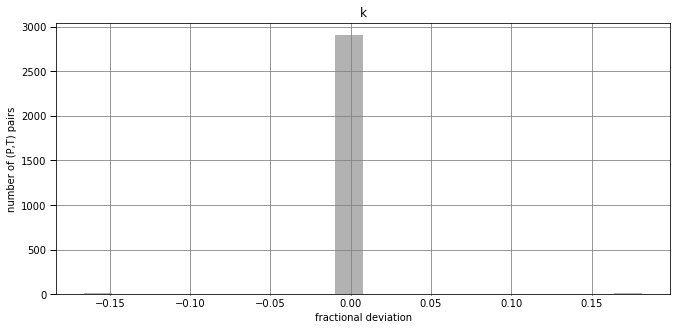

Figure. Fractional deviation of interpolated absorption coefficient from CRD at ktable (pressure, temperature) pairs


In [259]:
script_bilinear_interp()

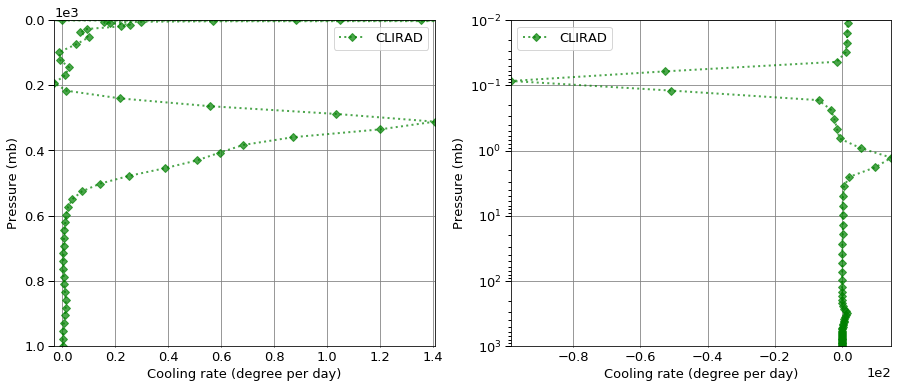

Figure: Cooling rate profile comparison.


In [260]:
script_plt_cooling()

In [268]:
script_tb_fluxg()

flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007271   0.000000  -0.007271
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017996   0.000000  -0.017996
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.050264   0.000000  -0.050264
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.113820   0.000000  -0.113820
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.339652   0.000000  -0.339652
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.717453   0.000000  -0.717453
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.367531   0.000000  -2.367531
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.049878   0.000000  -7.049878
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.381325   0.000000 -12.381325
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.186593   0.000000 -11.186593
   1013.0   76    -15.782424  15.777909  -0.004515

Table: TOA and SFC flux. CRD


flug          fldg      fnetg
g  pressure     level                                    
1  1.000000e-08 1      -0.007079  7.492490e-07  -0.007078
   1.013000e+03 76     -0.012622  3.951790e+00   3.939168
2  1.000000e-08 1      -0.017863  7.729977e-08  -0.017863
   1.013000e+03 76     -0.025648  1.130433e+01  11.278680
3  1.000000e-08 1     -12.321145  1.490116e-08 -12.321145
   1.013000e+03 76     -0.061703  1.848473e+01  18.423023
4  1.000000e-08 1     -11.264333  0.000000e+00 -11.264333
   1.013000e+03 76     -0.145286  1.536701e+01  15.221728
5  1.000000e-08 1      -0.339015  0.000000e+00  -0.339015
   1.013000e+03 76     -0.486309  4.851463e-01  -0.001162
6  1.000000e-08 1      -0.706174  0.000000e+00  -0.706174
   1.013000e+03 76     -1.141805  1.139077e+00  -0.002729
7  1.000000e-08 1      -2.128046  2.121147e+00  -0.006900
   1.013000e+03 76     -3.967865  3.958382e+00  -0.009483
8  1.000000e-08 1      -6.090610  6.072761e+00  -0.017849
   1.013000e+03 76    -11.360820  1.133367e+01  -0.027150
9  1.000000e-08 1     -12.321146  3.278256e-06 -12.321143
   1.013000e+03 76    -18.557241  1.851289e+01  -0.044350
10 1.000000e-08 1     -11.264334  5.960464e-08 -11.264334
   1.013000e+03 76    -15.332851  1.529621e+01  -0.036643

Table: TOA and SFC flux. CLIRAD


flug          fldg      fnetg
g  pressure level                                    
1  0.0      1       0.000192  7.492490e-07   0.000193
   1013.0   76     -0.000162  3.939333e+00   3.939171
2  0.0      1       0.000134  7.729977e-08   0.000134
   1013.0   76     -0.000121  1.127881e+01  11.278687
3  0.0      1     -12.270881  1.490116e-08 -12.270881
   1013.0   76     -0.000894  1.842393e+01  18.423038
4  0.0      1     -11.150513  0.000000e+00 -11.150513
   1013.0   76     -0.002690  1.522445e+01  15.221763
5  0.0      1       0.000637  0.000000e+00   0.000637
   1013.0   76     -0.009275  8.229640e-03  -0.001045
6  0.0      1       0.011280  0.000000e+00   0.011280
   1013.0   76     -0.022331  1.987560e-02  -0.002455
7  0.0      1       0.239485  2.121147e+00   2.360632
   1013.0   76     -0.075300  6.677180e-02  -0.008528
8  0.0      1       0.959268  6.072761e+00   7.032029
   1013.0   76     -0.190734  1.663420e-01  -0.024392
9  0.0      1       0.060179  3.278256e-06   0.060182
   1013.0   76     -0.166786  1.271020e-01  -0.039685
10 0.0      1      -0.077741  5.960464e-08  -0.077741
   1013.0   76      0.449573 -4.817010e-01  -0.032128

Table: TOA and SFC flux. (CLIRAD) - (CRD)


In [262]:
pd.set_option('display.max_rows', None)
display.display(DS_FLUX.sel(band=1).to_dataframe())
pd.reset_option('display.max_rows')

,band,level,sfu,sfd,fnet
pressure,,,,,
1.000000e-08,1,1,-32.849308,8.193699,-24.655609
6.244000e-04,1,2,-32.868252,8.193911,-24.674341
8.759000e-04,1,3,-32.908516,8.212922,-24.695595
1.228600e-03,1,4,-32.951275,8.253298,-24.697977
1.723400e-03,1,5,-32.994202,8.296209,-24.697992
2.417400e-03,1,6,-33.037273,8.339354,-24.697920
3.390900e-03,1,7,-33.080471,8.382721,-24.697750
4.756500e-03,1,8,-33.123829,8.426320,-24.697510
6.672000e-03,1,9,-33.167320,8.470192,-24.697128


In [263]:
script_debug()

# Debug Info

,k2,bd
0,0,27.310478
1,1,27.310478
2,2,27.373566
3,3,27.507750
4,4,27.650242
5,5,27.793293
6,6,27.936800
7,7,28.080740
8,8,28.225124
9,9,28.369965


,g,k1,k2,xx,trank,bd,fkw
0,1,0,1,-0.006746,0.999889,27.310478,0.000247
1,2,0,1,-0.013710,0.999994,27.310478,0.000502
2,3,0,1,-0.032982,1.000000,27.310478,0.001208
3,4,0,1,-0.077660,1.000000,27.310478,0.002844
4,5,0,1,-0.259948,1.000000,27.310478,0.009518
5,6,0,1,-0.610333,1.000000,27.310478,0.022348
6,7,0,1,0.000000,0.000000,27.310478,0.077661
7,8,0,1,0.000000,0.000000,27.310478,0.222359
8,9,0,1,-9.919472,1.000000,27.310478,0.363211
9,10,0,1,-8.195927,1.000000,27.310478,0.300102


h2oexp  w_diffuse      k_interp          dh2o
layer g                                                      
0     1   9.998890e-01        1.6  2.073889e-16  1.000000e-11
      2   9.999943e-01        1.8  9.354288e-18  1.000000e-11
      3   9.999996e-01        1.8  6.449497e-19  1.000000e-11
      4   1.000000e+00        1.8  5.216822e-21  1.000000e-11
      5   1.000000e+00        1.7  2.238399e-21  1.000000e-11
      6   1.000000e+00        1.6  5.507718e-22  1.000000e-11
      7   1.000000e+00        1.4  1.097676e-22  1.000000e-11
      8   1.000000e+00        1.4  2.676136e-22  1.000000e-11
      9   1.000000e+00        1.7  5.032505e-23  1.000000e-11
      10  1.000000e+00        1.8  2.259814e-24  1.000000e-11
1     1   9.721114e-01        1.6  2.073889e-16  2.547552e-09
      2   9.985658e-01        1.8  9.354288e-18  2.547552e-09
      3   9.999011e-01        1.8  6.449497e-19  2.547552e-09
      4   9.999992e-01        1.8  5.216822e-21  2.547552e-09
      5   9.999997e-01        1.7  2.238399e-21  2.547552e-09
      6   9.999999e-01        1.6  5.507718e-22  2.547552e-09
      7   1.000000e+00        1.4  1.097676e-22  2.547552e-09
      8   9.999999e-01        1.4  2.676136e-22  2.547552e-09
      9   1.000000e+00        1.7  5.032505e-23  2.547552e-09
      10  1.000000e+00        1.8  2.259814e-24  2.547552e-09
2     1   9.886547e-01        1.6  2.077051e-16  1.026120e-09
      2   9.994199e-01        1.8  9.389546e-18  1.026120e-09
      3   9.999601e-01        1.8  6.464274e-19  1.026120e-09
      4   9.999997e-01        1.8  5.217476e-21  1.026120e-09
      5   9.999999e-01        1.7  2.242044e-21  1.026120e-09
      6   9.999999e-01        1.6  5.520868e-22  1.026120e-09
      7   1.000000e+00        1.4  1.100861e-22  1.026120e-09
      8   1.000000e+00        1.4  2.682193e-22  1.026120e-09
      9   1.000000e+00        1.7  5.045322e-23  1.026120e-09
      10  1.000000e+00        1.8  2.272221e-24  1.026120e-09
3     1   9.840750e-01        1.6  2.083772e-16  1.439016e-09
      2   9.991801e-01        1.8  9.464477e-18  1.439016e-09
      3   9.999437e-01        1.8  6.495678e-19  1.439016e-09
      4   9.999995e-01        1.8  5.218861e-21  1.439016e-09
      5   9.999998e-01        1.7  2.249790e-21  1.439016e-09
      6   9.999999e-01        1.6  5.548817e-22  1.439016e-09
      7   1.000000e+00        1.4  1.107629e-22  1.439016e-09
      8   1.000000e+00        1.4  2.695066e-22  1.439016e-09
      9   1.000000e+00        1.7  5.072561e-23  1.439016e-09
      10  1.000000e+00        1.8  2.298589e-24  1.439016e-09
4     1   9.776555e-01        1.6  2.090899e-16  2.018784e-09
      2   9.988403e-01        1.8  9.543945e-18  2.018784e-09
      3   9.999206e-01        1.8  6.528985e-19  2.018784e-09
      4   9.999993e-01        1.8  5.220333e-21  2.018784e-09
      5   9.999998e-01        1.7  2.258005e-21  2.018784e-09
      6   9.999999e-01        1.6  5.578458e-22  2.018784e-09
      7   1.000000e+00        1.4  1.114807e-22  2.018784e-09
      8   1.000000e+00        1.4  2.708719e-22  2.018784e-09
      9   1.000000e+00        1.7  5.101450e-23  2.018784e-09
      10  1.000000e+00        1.8  2.326553e-24  2.018784e-09
5     1   9.686965e-01        1.6  2.098047e-16  2.831520e-09
      2   9.983602e-01        1.8  9.623635e-18  2.831520e-09
      3   9.998881e-01        1.8  6.562385e-19  2.831520e-09
      4   9.999991e-01        1.8  5.221808e-21  2.831520e-09
      5   9.999996e-01        1.7  2.266242e-21  2.831520e-09
      6   9.999999e-01        1.6  5.608182e-22  2.831520e-09
      7   1.000000e+00        1.4  1.122005e-22  2.831520e-09
      8   9.999999e-01        1.4  2.722409e-22  2.831520e-09
      9   1.000000e+00        1.7  5.130419e-23  2.831520e-09
      10  1.000000e+00        1.8  2.354595e-24  2.831520e-09
6     1   9.562223e-01        1.6  2.105208e-16  3.971880e-09
      2   9.976814e-01        1.8  9.703474e-18  3.971880e-09
      3   9.998422e-01        1.8  6.595845e-19 

In [264]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')